### Optimized Code from Zach for SVR Plots

SVR

In [2]:
!pip freeze

annoy==1.17.3
apparmor==2.13.3
apt-xapian-index==0.49
apturl==0.5.2
attrs==19.3.0
autobahn==17.10.1
Automat==0.8.0
backcall==0.1.0
bleach==3.1.1
blinker==1.4
brial==1.0.2
cbor==1.0.0
certifi==2019.11.28
chardet==3.0.4
Click==7.0
colorama==0.4.3
command-not-found==0.3
constantly==15.1.0
contourpy==1.1.1
cryptography==2.8
cupshelpers==1.0
cycler==0.10.0
Cython==0.29.14
dbus-python==1.2.16
decorator==4.4.2
defer==1.0.6
defusedxml==0.6.0
devscripts===2.20.2ubuntu2
distro==1.4.0
distro-info==0.23+ubuntu1.1
entrypoints==0.3
fail2ban==0.11.1
fenics-dijitso==2019.2.0.dev0
fenics-dolfin==2019.2.0.13.dev0
fenics-ffc==2019.2.0.dev0
fenics-fiat==2019.2.0.dev0
fenics-ufl==2022.1.0
fenics-ufl-legacy==2022.3.0
fonttools==4.53.0
freetype-py==2.4.0
gpg==1.13.1
graphlearning==1.6.9
hsluv==5.0.4
html5lib==1.0.1
httplib2==0.14.0
hyperlink==19.0.0
idna==2.8
importlib-metadata==1.5.0
importlib-resources==6.4.0
incremental==16.10.1
iotop==0.6
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
ipywidget

In [ ]:
!pip install numpy==1.23.5 pandas==2.0.3 scikit-learn==1.3.2 matplotlib==3.7.5 seaborn==0.13.2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import multiprocessing as mp
from itertools import product

## PROGRESS BAR ##
def svr_update_progress_bar(completed, total, bar_length=50):
    progress = int(bar_length * completed / total)
    bar = '#' * progress + '_' * (bar_length - progress)
    print(f'[{bar}] {completed}/{total} iterations completed', end='\r')

def svr_process_combination(args):
    svr_sex, svr_C, svr_epsilon, svr_run, svr_target_feature, svr_X, svr_y, svr_num_splits = args
    svr_kf = KFold(n_splits=svr_num_splits, shuffle=True, random_state=svr_run)
    svr_model = make_pipeline(StandardScaler(), SVR(kernel='linear', C=svr_C, epsilon=svr_epsilon))
    svr_rmses = []

    for svr_train_index, svr_test_index in svr_kf.split(svr_X):
        svr_X_train, svr_X_test = svr_X.iloc[svr_train_index], svr_X.iloc[svr_test_index]
        svr_y_train, svr_y_test = svr_y.iloc[svr_train_index], svr_y.iloc[svr_test_index]
        
        svr_model.fit(svr_X_train, svr_y_train)
        svr_predictions = svr_model.predict(svr_X_test)
        svr_rmse = 100 * sqrt(mean_squared_error(svr_y_test, svr_predictions)) / np.sqrt(np.mean(np.square(svr_y_test)))
        svr_rmses.append(svr_rmse)
    
    return np.mean(svr_rmses)

if __name__ == '__main__':
    print("Loading data...")
    svr_train_df = pd.read_csv('./../Data/complete_data.csv') # location of the data
    print("Data is loaded in, now running the model:")

    # different combinations of data choices # 
    svr_sexes = ['Male', 'Female', 'All']
    svr_target_features = ["BMD - Total", "% fat - Total", "ALM"]
    # different combinations of data choices # 

    # model parameter options # 
    svr_Cs = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 10, 50]
    svr_epsilons = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    svr_num_runs = 10
    svr_num_splits = 5
    # model parameter options # 

    # excluded columns to be dropped from x training data, including the combination and parameter options 
    svr_excluded_columns = ["0", "PPT ID", "Site", "Gender", "BMD - Total", "ALM", "% fat - Total", "Race"]

    # results tensor to store all results - by sex, C, Epsilon, and target features  - of 64-bit floating integers 
    svr_results_tensor = np.zeros((len(svr_sexes), len(svr_Cs), len(svr_epsilons), len(svr_target_features)), dtype=np.float64)

    # creates a list to iterate through for the sex, C, epsilon, rum runs, and number of taget features to iterate through - the tensor (multi-d array)
    svr_combinations = list(product(svr_sexes, svr_Cs, svr_epsilons, range(svr_num_runs), svr_target_features))
    svr_total_iterations = len(svr_combinations) # length of the combinations 

    # uses the multiprocessing library creating a 'pool' of worker processes - 1 for each cpu core
    with mp.Pool(processes=mp.cpu_count()) as svr_pool:
        svr_results = [] # buffer to hold results from an async run of a combination 
        # for all tasks in parameter cobinations 
        for svr_i, (svr_sex, svr_C, svr_epsilon, svr_run, svr_target_feature) in enumerate(svr_combinations):
            
            svr_filtered_df = svr_train_df if svr_sex == 'All' else svr_train_df[svr_train_df['Gender'] == svr_sex]
            svr_X = svr_filtered_df.drop(columns=svr_excluded_columns)
            svr_y = svr_filtered_df[svr_target_feature]
            
            svr_result = svr_pool.apply_async(svr_process_combination, 
                                              ((svr_sex, svr_C, svr_epsilon, svr_run, svr_target_feature, svr_X, svr_y, svr_num_splits),))
            
            svr_results.append((svr_sex, svr_C, svr_epsilon, svr_target_feature, svr_result))
            
            # updates the progress bar for iterations 
            svr_update_progress_bar(svr_i + 1, svr_total_iterations)

        for svr_sex, svr_C, svr_epsilon, svr_target_feature, svr_result in svr_results:
            svr_sex_idx = svr_sexes.index(svr_sex) # update the sex index
            svr_C_idx = svr_Cs.index(svr_C) # update hte C index
            svr_epsilon_idx = svr_epsilons.index(svr_epsilon)
            svr_target_feature_idx = svr_target_features.index(svr_target_feature)
            svr_results_tensor[svr_sex_idx, svr_C_idx, svr_epsilon_idx, svr_target_feature_idx] += svr_result.get() / svr_num_runs

    print('\nAll iterations completed.')


Loading data...
Data is loaded in, now running the model:
[##################################################] 12870/12870 iterations completed
All iterations completed.


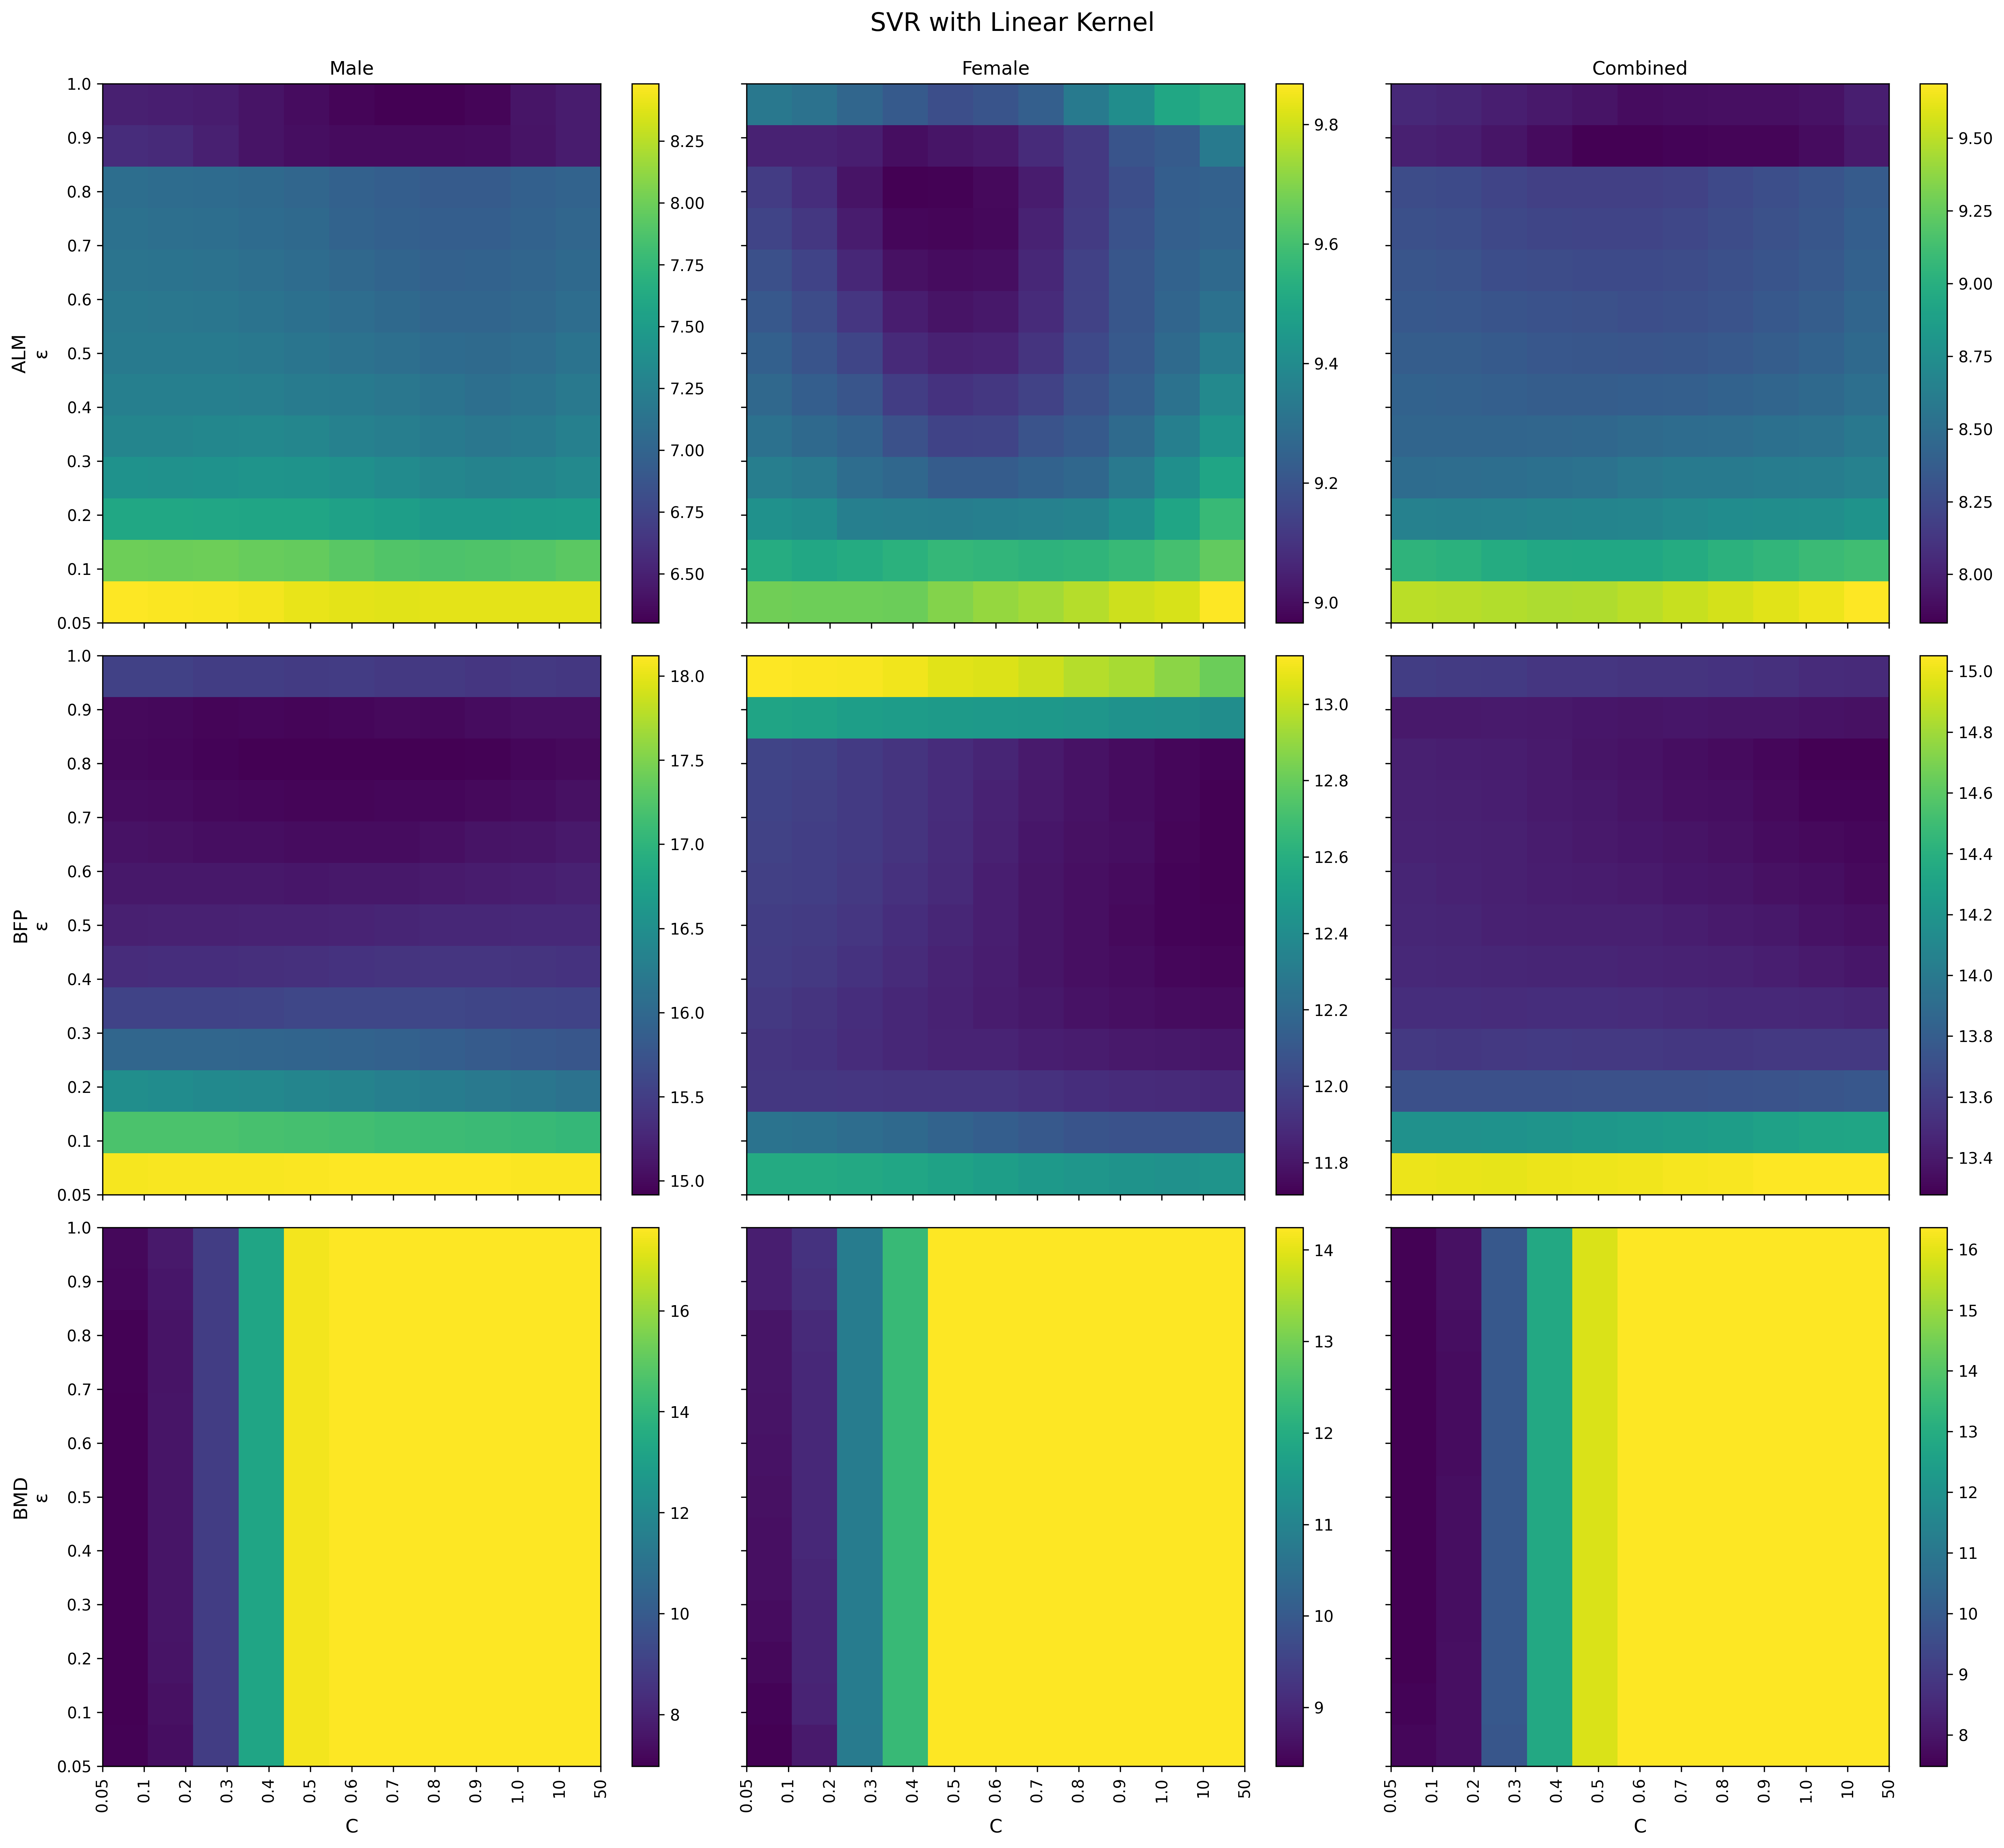

In [9]:
### OLD WRONG PLOT ###

import matplotlib.pyplot as plt
import numpy as np

# Ensure these match the order in your results tensor
svr_target_features = ["BMD - Total", "% fat - Total", "ALM"]
svr_sexes = ['Male', 'Female', 'All']
svr_row_titles = ['ALM', 'BFP', 'BMD']  # Order for display purposes
svr_column_titles = ['Male', 'Female', 'Combined']  # Display titles

# Create a figure to hold all subplots with specified DPI
fig, axes = plt.subplots(3, 3, figsize=(18, 18), dpi=300, facecolor='white')

# Map to correctly index the svr_results_tensor for the new row order
target_feature_map = {
    "ALM": 2,
    "% fat - Total": 1,
    "BMD - Total": 0
}

for i, svr_target in enumerate(["ALM", "% fat - Total", "BMD - Total"]):
    for j, svr_sex in enumerate(svr_sexes):
        ax = axes[i, j]
        
        # Extract the RMSE matrix for the current target and sex
        svr_rmse_matrix = svr_results_tensor[j, :, :, target_feature_map[svr_target]]
        
        # Plot the heatmap with correct orientation
        cax = ax.imshow(svr_rmse_matrix, cmap='viridis', aspect='auto', origin='lower',
                        extent=[0, len(svr_Cs)-1, 0, len(svr_epsilons)-1])
        
        # Set x-axis tick labels only for the bottom row
        if i == 2:
            ax.set_xlabel('C', fontsize=12)
            ax.set_xticks(range(len(svr_Cs)))
            ax.set_xticklabels(svr_Cs, rotation=90)
        else:
            ax.set_xticks(range(len(svr_Cs)))
            ax.set_xticklabels([])  # Remove labels for non-bottom rows
        
        # Set y-axis tick labels only for the leftmost column
        if j == 0:
            ax.set_ylabel(f'{svr_row_titles[i]}\n\u03B5', fontsize=12)  # Use Greek epsilon symbol
            ax.set_yticks(range(len(svr_epsilons)))
            ax.set_yticklabels(svr_epsilons)  # Ascending order
        else:
            ax.set_yticks(range(len(svr_epsilons)))
            ax.set_yticklabels([])  # Remove labels for non-leftmost columns
        
        # Set titles for the top row
        if i == 0:
            ax.set_title(svr_column_titles[j], fontsize=12)
        
        # Add colorbar
        fig.colorbar(cax, ax=ax)

plt.suptitle('SVR with Linear Kernel', fontsize=16, y=0.935)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

### OLD WRONG PLOT ###

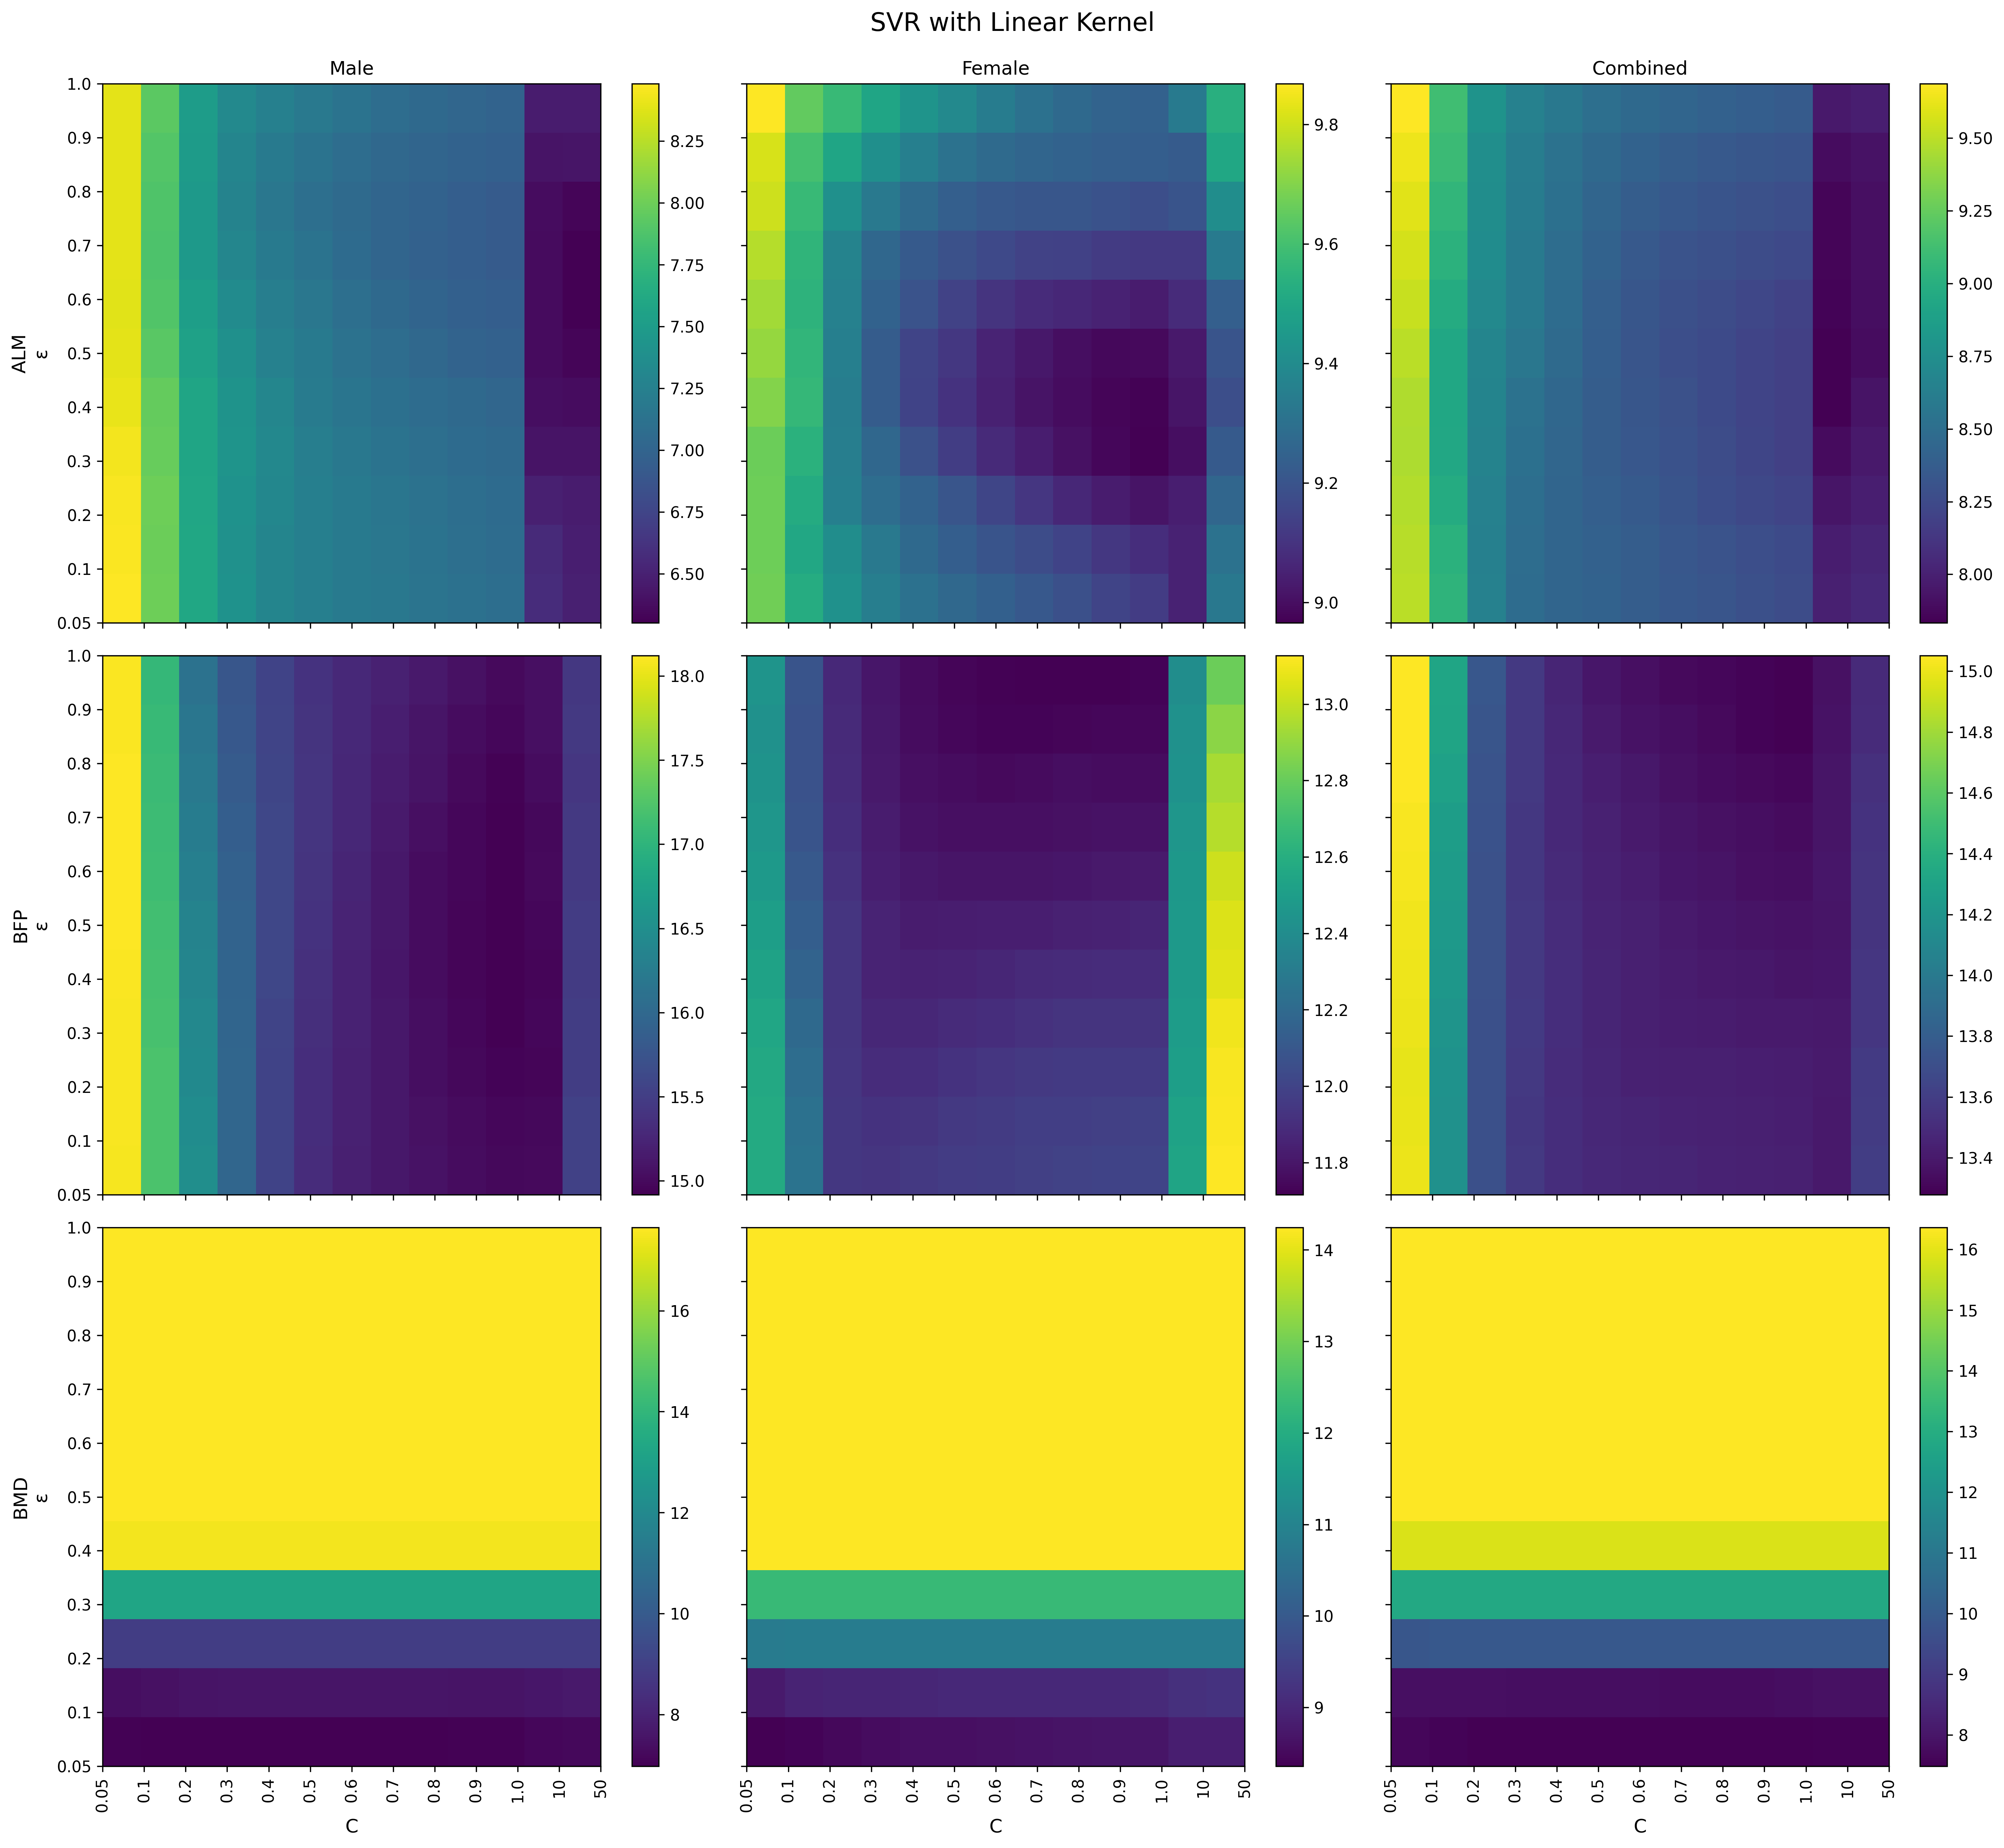

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure these match the order in your results tensor
svr_target_features = ["BMD - Total", "% fat - Total", "ALM"]
svr_sexes = ['Male', 'Female', 'All']
svr_row_titles = ['ALM', 'BFP', 'BMD']  # Top-to-bottom labels (top: ALM, middle: BFP, bottom: BMD)
svr_column_titles = ['Male', 'Female', 'Combined']  # Column titles

# Create a figure to hold all subplots with specified DPI
fig, axes = plt.subplots(3, 3, figsize=(18, 18), dpi=300, facecolor='white')

# Map to correctly index the svr_results_tensor for the new row order
target_feature_map = {
    "ALM": 2,
    "% fat - Total": 1,
    "BMD - Total": 0
}

# The loop order is set so that axes[0,*] is the top row and axes[2,*] the bottom row.
# Since you want the rows to be (from bottom) BMD, BFP, ALM,
# iterating in the order ["ALM", "% fat - Total", "BMD - Total"] assigns:
#   Top row (i=0) -> ALM, Middle row (i=1) -> % fat (BFP), Bottom row (i=2) -> BMD.
for i, svr_target in enumerate(["ALM", "% fat - Total", "BMD - Total"]):
    for j, svr_sex in enumerate(svr_sexes):
        ax = axes[i, j]
        
        # IMPORTANT: Transpose the matrix so that:
        # - x-axis corresponds to C (columns)
        # - y-axis corresponds to epsilon (rows)
        svr_rmse_matrix = svr_results_tensor[j, :, :, target_feature_map[svr_target]].T
        
        # Plot the heatmap with the desired orientation
        cax = ax.imshow(svr_rmse_matrix, cmap='viridis', aspect='auto', origin='lower',
                        extent=[0, len(svr_Cs)-1, 0, len(svr_epsilons)-1])
        
        # Set x-axis tick labels only for the bottom row (i == 2 because axes[2,*] is the bottom)
        if i == 2:
            ax.set_xlabel('C', fontsize=12)
            ax.set_xticks(range(len(svr_Cs)))
            ax.set_xticklabels(svr_Cs, rotation=90)
        else:
            ax.set_xticks(range(len(svr_Cs)))
            ax.set_xticklabels([])  # Remove labels for non-bottom rows
        
        # Set y-axis tick labels only for the leftmost column
        if j == 0:
            # The label here uses svr_row_titles[i] which, with i=0 as top, i=1 as middle, and i=2 as bottom,
            # results in top row labeled "ALM", middle "BFP", and bottom "BMD".
            ax.set_ylabel(f'{svr_row_titles[i]}\n\u03B5', fontsize=12)  # \u03B5 is the Greek epsilon
            ax.set_yticks(range(len(svr_epsilons)))
            ax.set_yticklabels(svr_epsilons)
        else:
            ax.set_yticks(range(len(svr_epsilons)))
            ax.set_yticklabels([])  # Remove labels for non-leftmost columns
        
        # Set titles for the top row
        if i == 0:
            ax.set_title(svr_column_titles[j], fontsize=12)
        
        # Add a colorbar for each subplot
        fig.colorbar(cax, ax=ax)

plt.suptitle('SVR with Linear Kernel', fontsize=16, y=0.935)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()



In [11]:
print("Best exact parameters:\n")
for svr_target_feature_idx, svr_target_feature in enumerate(svr_target_features):
    for svr_sex_idx, svr_sex in enumerate(svr_sexes):
        svr_best_idx = np.unravel_index(np.argmin(svr_results_tensor[svr_sex_idx, :, :, svr_target_feature_idx]),
                                        svr_results_tensor[svr_sex_idx, :, :, svr_target_feature_idx].shape)
        svr_best_C = svr_Cs[svr_best_idx[0]]
        svr_best_epsilon = svr_epsilons[svr_best_idx[1]]
        svr_best_rmse = svr_results_tensor[svr_sex_idx, svr_best_idx[0], svr_best_idx[1], svr_target_feature_idx]
        print(f"Best parameters for {svr_target_feature} ({svr_sex}):")
        print(f"  C: {svr_best_C}")
        print(f"  Epsilon: {svr_best_epsilon}")
        print(f"  RMSE: {svr_best_rmse:.4f}")
        print()

print("Best 'block' parameters:\n") # out of say, 50 runs, one block of heatmap:
for svr_target_feature_idx, svr_target_feature in enumerate(svr_target_features):
    for svr_sex_idx, svr_sex in enumerate(svr_sexes):
        # Extract the relevant RMSE tensor slice
        svr_rmse_matrix = svr_results_tensor[svr_sex_idx, :, :, svr_target_feature_idx]
        
        # Find the indices of the minimum RMSE (darkest square)
        svr_best_idx = np.unravel_index(np.argmin(svr_rmse_matrix), svr_rmse_matrix.shape)
        
        # Get the corresponding parameters
        svr_best_C = svr_Cs[svr_best_idx[0]]
        svr_best_epsilon = svr_epsilons[svr_best_idx[1]]
        svr_best_rmse = svr_rmse_matrix[svr_best_idx]
        
        # Print the results
        print(f"Best parameters for {svr_target_feature} ({svr_sex}):")
        print(f"  C: {svr_best_C}")
        print(f"  Epsilon: {svr_best_epsilon}")
        print(f"  RMSE: {svr_best_rmse:.4f}")

Best exact parameters:

Best parameters for BMD - Total (Male):
  C: 0.2
  Epsilon: 0.05
  RMSE: 6.9699

Best parameters for BMD - Total (Female):
  C: 0.05
  Epsilon: 0.05
  RMSE: 8.3568

Best parameters for BMD - Total (All):
  C: 0.4
  Epsilon: 0.05
  RMSE: 7.4807

Best parameters for % fat - Total (Male):
  C: 1.0
  Epsilon: 0.5
  RMSE: 14.9181

Best parameters for % fat - Total (Female):
  C: 0.7
  Epsilon: 1.0
  RMSE: 11.7165

Best parameters for % fat - Total (All):
  C: 1.0
  Epsilon: 1.0
  RMSE: 13.2790

Best parameters for ALM (Male):
  C: 50
  Epsilon: 0.7
  RMSE: 6.3016

Best parameters for ALM (Female):
  C: 1.0
  Epsilon: 0.3
  RMSE: 8.9661

Best parameters for ALM (All):
  C: 10
  Epsilon: 0.4
  RMSE: 7.8337

Best 'block' parameters:

Best parameters for BMD - Total (Male):
  C: 0.2
  Epsilon: 0.05
  RMSE: 6.9699
Best parameters for BMD - Total (Female):
  C: 0.05
  Epsilon: 0.05
  RMSE: 8.3568
Best parameters for BMD - Total (All):
  C: 0.4
  Epsilon: 0.05
  RMSE: 7.480

LSSVR

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import multiprocessing as mp
from itertools import product
from lssvr import LSSVR

def lssvr_update_progress_bar(completed, total, bar_length=50):
    progress = int(bar_length * completed / total)
    bar = '#' * progress + '_' * (bar_length - progress)
    print(f'[{bar}] {completed}/{total} iterations completed', end='\r')

def lssvr_process_lssvr_combination(args):
    lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature, lssvr_X, lssvr_y, lssvr_num_splits = args
    lssvr_kf = KFold(n_splits=lssvr_num_splits, shuffle=True, random_state=lssvr_run)
    lssvr_rmses = []

    for lssvr_train_index, lssvr_test_index in lssvr_kf.split(lssvr_X):
        lssvr_X_train, lssvr_X_test = lssvr_X.iloc[lssvr_train_index], lssvr_X.iloc[lssvr_test_index]
        lssvr_y_train, lssvr_y_test = lssvr_y.iloc[lssvr_train_index], lssvr_y.iloc[lssvr_test_index]

        # Standardize features
        lssvr_scaler = StandardScaler()
        lssvr_X_train_scaled = lssvr_scaler.fit_transform(lssvr_X_train)
        lssvr_X_test_scaled = lssvr_scaler.transform(lssvr_X_test)

        # Ensure lssvr_y_train is a numpy array for proper indexing
        lssvr_y_train = lssvr_y_train.values

        lssvr_model = LSSVR(kernel='rbf', gamma=lssvr_gamma, C=lssvr_C)
        lssvr_model.fit(lssvr_X_train_scaled, lssvr_y_train)

        lssvr_predictions = lssvr_model.predict(lssvr_X_test_scaled)
        lssvr_rmse = 100 * sqrt(mean_squared_error(lssvr_y_test, lssvr_predictions)) / np.sqrt(np.mean(np.square(lssvr_y_test)))
        lssvr_rmses.append(lssvr_rmse)

    return np.mean(lssvr_rmses)

if __name__ == '__main__':
    print("Loading data...")
    lssvr_train_df = pd.read_csv('./../Data/complete_data.csv')
    print("Data is loaded in, now running the model:")

    lssvr_sexes = ['All', 'Male', 'Female']
    lssvr_target_features = ["ALM", "% fat - Total", "BMD - Total"]

    lssvr_gammas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
    # ^ gamma controls the influence of individual training samples(low valures are 'far' while high values are 'close')
    lssvr_Cs = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000, 10000]
    # ^ C regulization parameter controls the trade-off between achieving a low training error and a low testing error
    lssvr_num_runs = 10  # Increased for more robust results
    lssvr_num_splits = 5

    lssvr_excluded_columns = ["PPT ID", "Site", "Gender", "Race", "BMD - Total", "ALM", "% fat - Total"]

    lssvr_results_tensor = np.zeros((len(lssvr_sexes), len(lssvr_gammas), len(lssvr_Cs), len(lssvr_target_features)))

    lssvr_combinations = list(product(lssvr_sexes, lssvr_gammas, lssvr_Cs, range(lssvr_num_runs), lssvr_target_features))
    lssvr_total_iterations = len(lssvr_combinations)

    with mp.Pool(processes=mp.cpu_count()) as lssvr_pool:
        lssvr_results = []
        for lssvr_i, (lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature) in enumerate(lssvr_combinations):
            lssvr_filtered_df = lssvr_train_df if lssvr_sex == 'All' else lssvr_train_df[lssvr_train_df['Gender'] == lssvr_sex]
            lssvr_X = lssvr_filtered_df.drop(columns=lssvr_excluded_columns)
            lssvr_y = lssvr_filtered_df[lssvr_target_feature]
            
            lssvr_result = lssvr_pool.apply_async(lssvr_process_lssvr_combination, 
                                                  ((lssvr_sex, lssvr_gamma, lssvr_C, lssvr_run, lssvr_target_feature, lssvr_X, lssvr_y, lssvr_num_splits),))
            lssvr_results.append((lssvr_sex, lssvr_gamma, lssvr_C, lssvr_target_feature, lssvr_result))
            
            lssvr_update_progress_bar(lssvr_i + 1, lssvr_total_iterations)

        for lssvr_sex, lssvr_gamma, lssvr_C, lssvr_target_feature, lssvr_result in lssvr_results:
            lssvr_sex_idx = lssvr_sexes.index(lssvr_sex)
            lssvr_gamma_idx = lssvr_gammas.index(lssvr_gamma)
            lssvr_C_idx = lssvr_Cs.index(lssvr_C)
            lssvr_target_feature_idx = lssvr_target_features.index(lssvr_target_feature)
            lssvr_results_tensor[lssvr_sex_idx, lssvr_gamma_idx, lssvr_C_idx, lssvr_target_feature_idx] += lssvr_result.get() / lssvr_num_runs

    print('\nAll iterations completed.')

Loading data...
Data is loaded in, now running the model:
[##################################################] 6480/6480 iterations completed
All iterations completed.


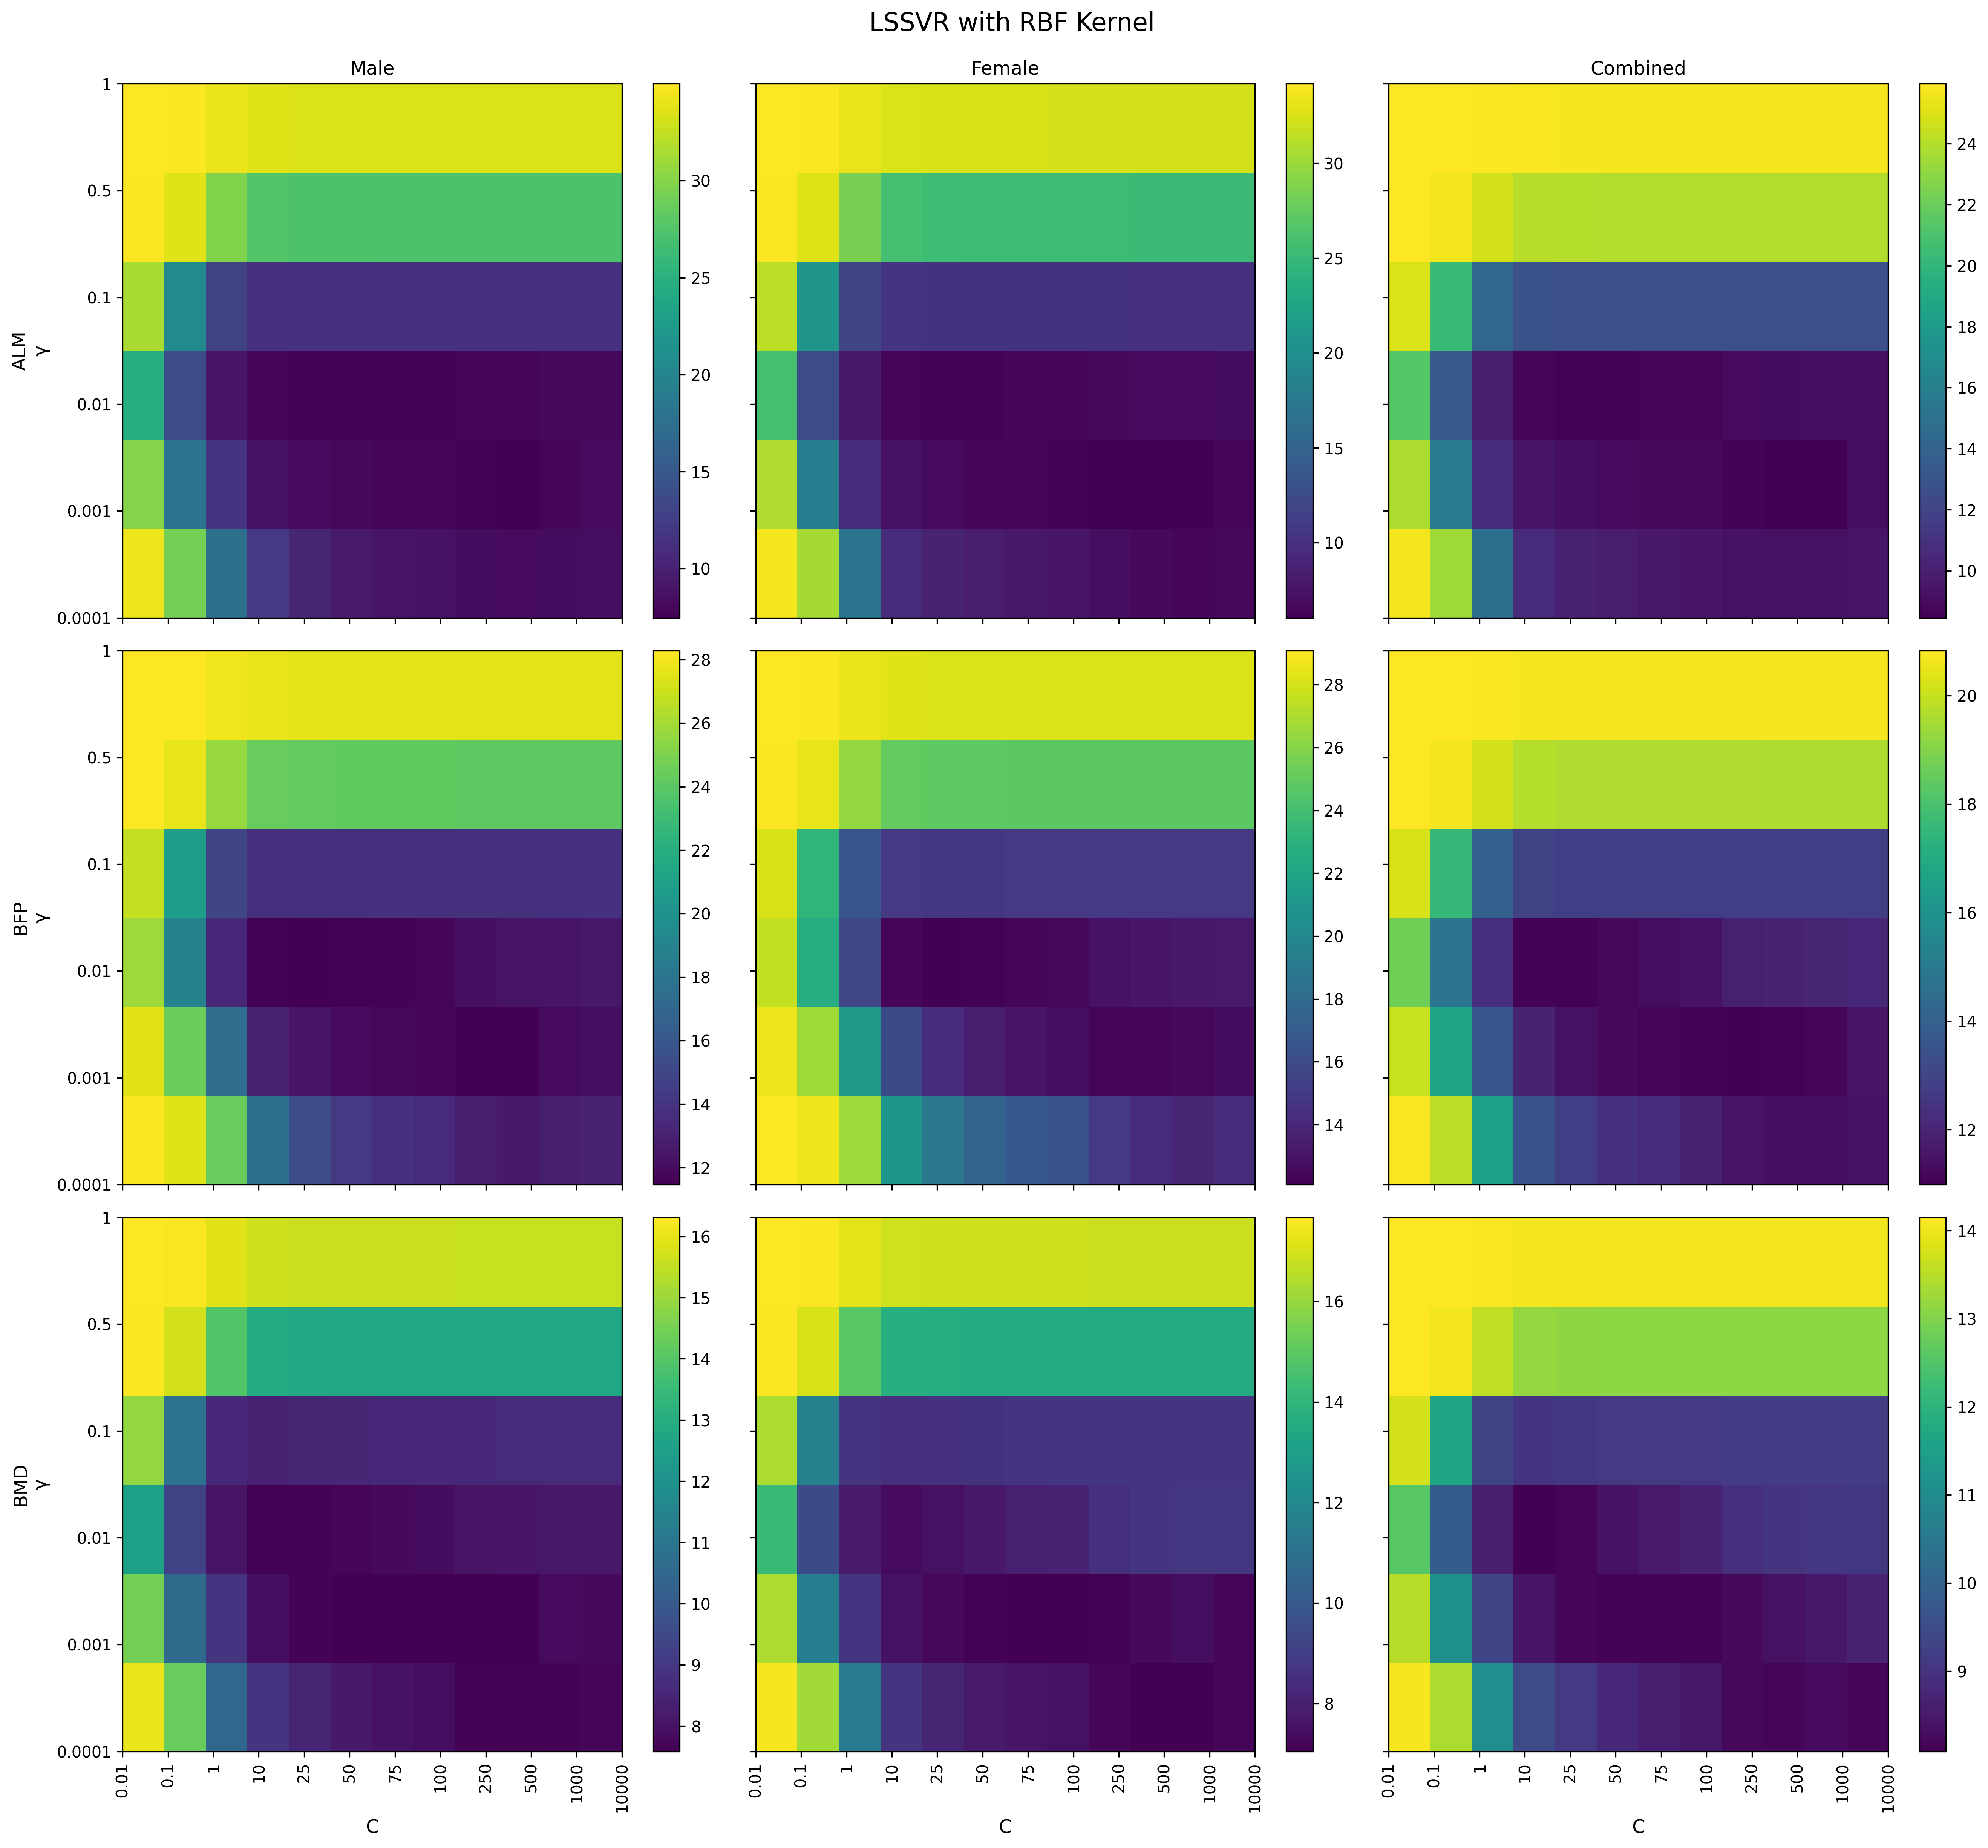

Best parameters for ALM (Male):
  Gamma: 0.001
  C: 500
  RMSE: 7.4697

Best parameters for ALM (Female):
  Gamma: 0.001
  C: 1000
  RMSE: 6.0332

Best parameters for ALM (All):
  Gamma: 0.001
  C: 1000
  RMSE: 8.4602

Best parameters for % fat - Total (Male):
  Gamma: 0.01
  C: 25
  RMSE: 11.4655

Best parameters for % fat - Total (Female):
  Gamma: 0.01
  C: 25
  RMSE: 12.0940

Best parameters for % fat - Total (All):
  Gamma: 0.001
  C: 250
  RMSE: 10.9861

Best parameters for BMD - Total (Male):
  Gamma: 0.001
  C: 250
  RMSE: 7.5873

Best parameters for BMD - Total (Female):
  Gamma: 0.001
  C: 100
  RMSE: 7.0485

Best parameters for BMD - Total (All):
  Gamma: 0.01
  C: 10
  RMSE: 8.0894



In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure these match the order in your results tensor
lssvr_target_features = ["ALM", "% fat - Total", "BMD - Total"]
lssvr_sexes = ['Male', 'Female', 'All']
lssvr_row_titles = ['ALM', 'BFP', 'BMD']  # Order for display purposes
lssvr_column_titles = ['Male', 'Female', 'Combined']  # Display titles

# Create a figure to hold all subplots with specified DPI
fig, axes = plt.subplots(3, 3, figsize=(18, 18), dpi=300, facecolor='white')

# Map to correctly index the lssvr_results_tensor for the new row order
target_feature_map = {
    "ALM": 0,
    "% fat - Total": 1,
    "BMD - Total": 2
}

for i, lssvr_target in enumerate(["ALM", "% fat - Total", "BMD - Total"]):
    for j, lssvr_sex in enumerate(lssvr_sexes):
        ax = axes[i, j]
        
        # Extract the RMSE matrix for the current target and sex
        lssvr_rmse_matrix = lssvr_results_tensor[j, :, :, target_feature_map[lssvr_target]]
        
        # Plot the heatmap with correct orientation
        cax = ax.imshow(lssvr_rmse_matrix, cmap='viridis', aspect='auto', origin='lower',
                        extent=[0, len(lssvr_Cs)-1, 0, len(lssvr_gammas)-1])
        
        # Set x-axis tick labels only for the bottom row
        if i == 2:
            ax.set_xlabel('C', fontsize=12)
            ax.set_xticks(range(len(lssvr_Cs)))
            ax.set_xticklabels(lssvr_Cs, rotation=90)
        else:
            ax.set_xticks(range(len(lssvr_Cs)))
            ax.set_xticklabels([])  # Remove labels for non-bottom rows
        
        # Set y-axis tick labels only for the leftmost column
        if j == 0:
            ax.set_ylabel(f'{lssvr_row_titles[i]}\n\u03B3', fontsize=12)  # Use Greek gamma symbol
            ax.set_yticks(range(len(lssvr_gammas)))
            ax.set_yticklabels(lssvr_gammas)  # Ascending order
        else:
            ax.set_yticks(range(len(lssvr_gammas)))
            ax.set_yticklabels([])  # Remove labels for non-leftmost columns
        
        # Set titles for the top row
        if i == 0:
            ax.set_title(lssvr_column_titles[j], fontsize=12)
        
        # Add colorbar
        fig.colorbar(cax, ax=ax)

plt.suptitle('LSSVR with RBF Kernel', fontsize=16, y=0.935)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

# Find and print the best parameters
for lssvr_target_feature_idx, lssvr_target_feature in enumerate(lssvr_target_features):
    for lssvr_sex_idx, lssvr_sex in enumerate(lssvr_sexes):
        lssvr_best_idx = np.unravel_index(np.argmin(lssvr_results_tensor[lssvr_sex_idx, :, :, lssvr_target_feature_idx]),
                                          lssvr_results_tensor[lssvr_sex_idx, :, :, lssvr_target_feature_idx].shape)
        lssvr_best_gamma = lssvr_gammas[lssvr_best_idx[0]]
        lssvr_best_C = lssvr_Cs[lssvr_best_idx[1]]
        lssvr_best_rmse = lssvr_results_tensor[lssvr_sex_idx, lssvr_best_idx[0], lssvr_best_idx[1], lssvr_target_feature_idx]
        print(f"Best parameters for {lssvr_target_feature} ({lssvr_sex}):")
        print(f"  Gamma: {lssvr_best_gamma}")
        print(f"  C: {lssvr_best_C}")
        print(f"  RMSE: {lssvr_best_rmse:.4f}")
        print()
